# En datadriven analys av "the Show About Nothing"
Syftet med min analys är att undersöka hur tittarsiffror, IMDb-betyg och karaktärers påverkan bidrog till Seinfelds framgång. Jag vill också se om externa faktorer, som sändningstider eller sändningsdagar, påverkade seriens popularitet.

## Data och Metoder

För att analysera Seinfeld-serien har jag samlat in data från flera källor:

1. **Wikipedia**  
   Genom web scraping hämtade jag information om varje avsnitt, inklusive:  
   - Originalvisningsdatum  
   - Manusförfattare  
   - Episodtitlar  
   - Säsongs- och avsnittsnummer  
   - Tittarsiffror  

2. **IMDb**  
   Jag web-scrapea IMDb för att samla in betyg för varje avsnitt.

3. **Manusskript**  
   Jag hittade ett dataset som innehåller (nästan) alla repliker från serien, organiserade per avsnitt och karaktär. Detta gjorde det möjligt att analysera vilka karaktärer som dominerade dialogerna och hur detta påverkade avsnittens betyg.

4. **Sändningstider**  
   På hemsidan [www.classic-tv.com](https://www.classic-tv.com) hittade jag alla NBC:s original-sändningstider, som jag manuellt lade till i min databas.

## Svårigheter med data

1. **Saknade manuskript**  
   Fyra avsnitt, som alla var återblicksavsnitt (så kallade "clip shows"), saknade manuskript. Jag misstänker att dessa data är hämtade från [Seinfeld Scripts](https://www.seinfeldscripts.com), där samma avsnitt saknar manus. Då dessa avsnitt främst bestod av återblickar, valde jag att bortse från detta datagap.

2. **Dubbelavsnitt**  
   På IMDb räknas dubbelavsnitt, som till exempel *The Raincoats*, som ett enda avsnitt, tillskillnad från Wikipedia behandlar varje halva som separata avsnitt. Jag identifierade dessa dubbelavsnitt och delade manuellt upp raderna i IMDb-datan för att matcha Wikipedias struktur.

3. **Matchning mellan dataset**  
   Liknande problem uppstod när jag ville kombinera Wikipedia-datan med manuskript-datan. Även här hanterades problemet genom att manuellt anpassa och justera data för att säkerställa konsekvens mellan dataseten.

Vid sammanslagningen av IMDb-datan med Wikipedia-datan upptäcktes vissa skillnader i stavningen av avsnittstitlar, till exempel:  
- *"The Stake Out"* på Wikipedia motsvarade *"The Stakeout"* på IMDb.  

Detta gällde ett fåtal titlar, och dessa korrigerades manuellt efter identifiering. Genom att anpassa titlarna säkerställde jag att datan från de två källorna kunde matchas korrekt.

4. **Inkonsekvent benäming av karaktärernas namn** 
    I script-data märkte jag att man hade inte varit helt konsekvent med hur man skriv karaktärernas namn, någon gång stod det Jerry, JERRY(IN HIS MIND), GEORGE & JERRY etc. Detta hanterades med lösningar med Regex. 

## Inhämtning av Data

### Wikipedia
Vi börjar med att hämta information om varje Seinfeld-avsnitt från Wikipedia:

In [78]:
library(rvest)
library(dplyr)
library(purrr)
library(ggplot2)
library(knitr)
library(hms)
library(lubridate)
library(patchwork)
library(tidyr)
library(stringr)
options(warn = -1)


url <- "https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_avsnitt_av_Seinfeld#Avsnitt"

#hämta tabellerna med säsongsdata
tables <- read_html(url) %>% 
  html_nodes("table.wikitable.plainrowheaders") %>%
  html_table(fill = TRUE)

#första tabellen är inte relevant
tables <- tables[-1]


#lägg till säsong i tabellerna och ändra så alla kolumner har matchande namn
for(i in seq(length(tables))){
  tables[[i]] <- tables[[i]] %>%
  select(-matches("^Prod\\.kod")) %>%
  mutate(säsong = i) 
  colnames(tables[[i]]) <- gsub("Originalvisning\u00A0\\[6\\]", "Originalvisning", colnames(tables[[i]]))
}

#lägger ihop alla säsongers data-frames
episode_df <- reduce(tables, full_join, by = colnames(tables[[1]]))


#ändrar tittarsiffror från antal miljoner till ental
episode_df <- episode_df %>%
  mutate(Tittarsiffror = 1000000*as.numeric(gsub("\\[.*\\]", "", `Tittarsiffror(miljoner)`))) %>% 
  select(-`Tittarsiffror(miljoner)`)

#tar bort mellanslag i titalrna
episode_df$Titel <- gsub("^\"|\"$", "", episode_df$Titel)


## Visa ansnitt är dubbel avsnitt, delar upp de i två delar.

# skapa en lista med alla dubbelavsnitt som ska delas
episodes_to_split <- list(
  list(
    Titel = "The Trip",
    NewTitles = c("The Trip: Part 1", "The Trip: Part 2"),
    NrIserien = c(41, 42),
    NrIsäsongen = c(1, 2),
    Originalvisning = c("12 augusti 1992 (1992-08-12)", "19 augusti 1992 (1992-08-19)"),
    Tittarsiffror = c(16300000, 15100000)
  ),
  list(
    Titel = "The Boyfriend\"\"The New Friend",
    NewTitles = c("The Boyfriend", "The Boyfriend"),
    NrIserien = c(34, 35),
    NrIsäsongen = c(17, 18)
  ),
  list(
    Titel = "The Pilot",
    NrIserien = c(63, 64),
    NrIsäsongen = c(23, 24)
  ),
  list(
    Titel = "The Raincoats",
    NrIserien = c(82, 83),
    NrIsäsongen = c(18, 19)
  ),
  list(
    Titel = "The Highlights of 100",
    NewTitles = c("The Highlights of a Hundred", "The Highlights of a Hundred"),
    NrIserien = c(100, 101),
    NrIsäsongen = c(14, 15)
  ),
  list(
    Titel = "The Cadillac",
    NrIserien = c(124, 125),
    NrIsäsongen = c(14, 15)
  ),
  list(
    Titel = "The Bottle Deposit",
    NrIserien = c(131, 132),
    NrIsäsongen = c(21, 22)
  ),
  list(
    Titel = "The Chronicle\"\"The Clip Show",
    NewTitles = c("The Chronicle", "The Chronicle"),
    NrIserien = c(177, 178),
    NrIsäsongen = c(21, 22)
  ),
  list(
    Titel = "The Finale",
    NrIserien = c(179, 180),
    NrIsäsongen = c(23, 24)
  )
)

# generera dubbletter och uppdatera dataframe
split_episodes <- lapply(episodes_to_split, function(ep) {
  new_df <- episode_df %>%
    filter(Titel == ep$Titel) %>%
    dplyr::slice(rep(1, 2)) %>%
    mutate(
      Titel = ifelse(!is.null(ep$NewTitles), ep$NewTitles, Titel),
      `Nr iserien` = ep$NrIserien,
      `Nr isäsongen` = ep$NrIsäsongen,
      Originalvisning = ifelse(!is.null(ep$Originalvisning), ep$Originalvisning, Originalvisning),
      Tittarsiffror = ifelse(!is.null(ep$Tittarsiffror), ep$Tittarsiffror, Tittarsiffror)
    )
  return(new_df)
})

# kombinera allt till en dataframe
episode_df <- episode_df %>%
  filter(!(Titel %in% sapply(episodes_to_split, function(x) x$Titel))) %>%
  bind_rows(do.call(rbind, split_episodes))

# Avsnittet "The Pie" saknar tittarsiffror, tar medelvärdet av avsnitten innan & efter
episode_df <- episode_df %>% 
  mutate(Tittarsiffror = ifelse(is.na(Tittarsiffror),
        (lag(Tittarsiffror, default = NA) + lead(Tittarsiffror, default = NA)) / 2,
        Tittarsiffror) )

Vi kan se en kort sammanställning av datan från Wikipedia här nedan:

In [79]:
head(episode_df)

Nr iserien,Nr isäsongen,Titel,Regissör,Manus,Originalvisning,säsong,Tittarsiffror
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,1,The Seinfeld Chronicles,Art Wolff,Larry David & Jerry Seinfeld,5 juli 1989 (1989-07-05),1,15400000
2,2,The Stake Out,Tom Cherones,Larry David & Jerry Seinfeld,31 maj 1990 (1990-05-31),1,22500000
3,3,The Robbery,Tom Cherones,Matt Goldman,7 juni 1990 (1990-06-07),1,19700000
4,4,Male Unbonding,Tom Cherones,Larry David & Jerry Seinfeld,14 juni 1990 (1990-06-14),1,19100000
5,5,The Stock Tip,Tom Cherones,Larry David & Jerry Seinfeld,21 juni 1990 (1990-06-21),1,19400000
6,1,The Ex-Girlfriend,Tom Cherones,Larry David & Jerry Seinfeld,23 januari 1991 (1991-01-23),2,15600000


###  Hämtar Imdb-betyg
Vi går sedan vidare med att hämta IMDB-betyg för varje avsnitt.

Hantar problem så som:  
 - Symboler i kolumnnamn.  
 - Titlarna skiljer sig något mellan IMDB & Wikipedia.  

In [76]:
# scrapar imdb betyg
imdb_base<- "https://www.imdb.com/title/tt0098904/episodes/?season="
titles <- c()
betyg <- c()
for(i in 1:9){
  page_url <- paste0(imdb_base,i)
  html_page <- read_html(page_url)
  title <- html_page %>% 
    html_nodes("a.ipc-title-link-wrapper") %>% 
    html_nodes("div.ipc-title__text") %>% 
    html_text() 
  titles <- c(titles,title)
  
  rating <- html_page %>% 
    html_nodes("span.ipc-rating-star--rating") %>% 
    html_text()
  betyg <- c(betyg,rating) 
}


# tar bort ett nummer som kom med under scrapingen
imdb_betyg_df <- data.frame(Titel = titles,
                              betyg = betyg)
imdb_betyg_df$Titel <- sub("^S\\d+\\.E\\d+\\s*∙\\s*", "", imdb_betyg_df$Titel)
imdb_betyg_df$Titel[1] <- episode_df$Titel[1] #piloten hade två namn, "Good News, Bad News" & "The Seinfeld Chronicles"(som vi behåller).

# några titlar hade olika stavningar på Wiki än på IMBD
imdb_betyg_df$Titel[imdb_betyg_df$Titel == "The Stakeout"] <- "The Stake Out"
imdb_betyg_df$Titel[imdb_betyg_df$Titel == "The Cafe"] <- "The Café"
imdb_betyg_df$Titel[imdb_betyg_df$Titel == "The Fix Up"] <- "The Fix-Up"
imdb_betyg_df$Titel[imdb_betyg_df$Titel == "The Mom and Pop Store"] <- "The Mom & Pop Store"
imdb_betyg_df$Titel[imdb_betyg_df$Titel == "The Friars Club"] <- "The Friar's Club"

Här är en överblick av den sammanställda IMDB-datan:

In [73]:
head(imdb_betyg_df)

,Titel,betyg
,<chr>,<chr>
1,The Seinfeld Chronicles,7.3
2,The Stake Out,7.5
3,The Robbery,7.4
4,Male Unbonding,7.2
5,The Stock Tip,7.4
6,The Ex-Girlfriend,7.5


### Sammanställer de två dataseten
Vi sätter ihop wiki-datan & imdb-datan:

In [80]:
# joining imdb & wiki data, gör betyget till numerisk också
seinfeld_df <- left_join(episode_df,imdb_betyg_df,by ="Titel") %>% 
  select(Titel,betyg,everything()) %>% 
  mutate(betyg = as.numeric(betyg))

Här har vi den uppdaterade ihopslagningen:

In [81]:
head(seinfeld_df)

Titel,betyg,Nr iserien,Nr isäsongen,Regissör,Manus,Originalvisning,säsong,Tittarsiffror
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>
The Seinfeld Chronicles,7.3,1,1,Art Wolff,Larry David & Jerry Seinfeld,5 juli 1989 (1989-07-05),1,15400000
The Stake Out,7.5,2,2,Tom Cherones,Larry David & Jerry Seinfeld,31 maj 1990 (1990-05-31),1,22500000
The Robbery,7.4,3,3,Tom Cherones,Matt Goldman,7 juni 1990 (1990-06-07),1,19700000
Male Unbonding,7.2,4,4,Tom Cherones,Larry David & Jerry Seinfeld,14 juni 1990 (1990-06-14),1,19100000
The Stock Tip,7.4,5,5,Tom Cherones,Larry David & Jerry Seinfeld,21 juni 1990 (1990-06-21),1,19400000
The Ex-Girlfriend,7.5,6,1,Tom Cherones,Larry David & Jerry Seinfeld,23 januari 1991 (1991-01-23),2,15600000


### Finslipa datan
Sedan sorteras datan efter kronologiskordning, vi skriver datum på YMD-format, och lägger till SEID (e.g, "S01E01"). Piloten sätts som S00E00. Nedanför visas en uppdaterad version av datasetet.

In [82]:
seinfeld_df <- seinfeld_df %>% 
  mutate(`Nr isäsongen` = ifelse(säsong ==1,`Nr isäsongen`-1,`Nr isäsongen`)) %>% #korrigerar för att vi definerar Piloten som fristående avsnitt (säsong 0 episode 0)
  mutate(säsong = ifelse(Titel =="The Seinfeld Chronicles",0,säsong)) %>% 
  arrange(`Nr iserien`) %>% 
  mutate(SEID = sprintf("S%02dE%02d", säsong, `Nr isäsongen`))%>% # pilot sätts S01E00
  select(Titel,SEID,everything()) %>% 
  mutate(
    Originalvisning_hms = gsub(".*\\(([^)]+)\\)", "\\1", Originalvisning),
    Originalvisning_hms = as.Date(Originalvisning_hms, format = "%Y-%m-%d"),
    Originalvisning = Originalvisning_hms) %>% 
  select(-Originalvisning_hms) 

head(seinfeld_df %>% select(-c(Regissör,Manus)))

Titel,SEID,betyg,Nr iserien,Nr isäsongen,Originalvisning,säsong,Tittarsiffror
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>
The Seinfeld Chronicles,S00E00,7.3,1,0,1989-07-05,0,15400000
The Stake Out,S01E01,7.5,2,1,1990-05-31,1,22500000
The Robbery,S01E02,7.4,3,2,1990-06-07,1,19700000
Male Unbonding,S01E03,7.2,4,3,1990-06-14,1,19100000
The Stock Tip,S01E04,7.4,5,4,1990-06-21,1,19400000
The Ex-Girlfriend,S02E01,7.5,6,1,1991-01-23,2,15600000


### Vilka dagar & tider söndes säsonger på?  

Vi använder datan från www.classic-tv.com, som angav vilka tider episoderna sändes, för att manuellt uppdatera datasetet med sändingstider & funktionen `weekdays()` för att hitta veckodag.  Nedanför visas en uppdaterad version av datasetet.

In [91]:
 invisible(Sys.setlocale("LC_TIME", "en_US")) # ändrar språket till engelska, pga weekdays() (tekniskt detalj)
# funktion som mappar tiden avsnittet sändes.
get_broadcast_period <- function(air_date) {
  if ( air_date <= as.Date("1990-07-31")) {
    return("21:30:00")  
  } else if (air_date >= as.Date("1991-01-01") & air_date <= as.Date("1991-02-28")) {
    return("21:30:00")
  } else if (air_date >= as.Date("1991-04-01") & air_date <= as.Date("1991-06-30")) {
    return("21:30:00")
  } else if (air_date >= as.Date("1991-06-01") & air_date <= as.Date("1991-12-31")) {
    return("21:30:00")
  } else if (air_date >= as.Date("1991-12-01") & air_date <= as.Date("1993-01-31")) {
    return("21:00:00") 
  } else if (air_date >= as.Date("1993-02-01") & air_date <= as.Date("1993-08-31")) {
    return("21:30:00") 
  } else if (air_date >= as.Date("1993-08-01") & air_date <= as.Date("1998-05-31")) {
    return("21:00:00") 
  } else {
    return(NA)  
  }
}
seinfeld_df <- seinfeld_df %>%
  mutate(sändningstid = sapply(Originalvisning, get_broadcast_period)) %>% #tillämpar funktionen ovan för att mappa sändningstider
  mutate(sändningstid = as.factor(sändningstid)) %>% # sändningstiderna till faktorer 
  mutate(sändningstid = factor(sändningstid, levels = c("21:00:00", "21:30:00")))  %>%
  mutate(veckodagar= weekdays(Originalvisning))  %>%
  mutate(veckodagar = ifelse(veckodagar == "Wednesday","Onsdag","Torsdag")) 

head(seinfeld_df %>% select(-c(Regissör,Manus)))



Titel,SEID,betyg,Nr iserien,Nr isäsongen,Originalvisning,säsong,Tittarsiffror,sändningstid,veckodagar
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<chr>
The Seinfeld Chronicles,S00E00,7.3,1,0,1989-07-05,0,15400000,21:30:00,Onsdag
The Stake Out,S01E01,7.5,2,1,1990-05-31,1,22500000,21:30:00,Torsdag
The Robbery,S01E02,7.4,3,2,1990-06-07,1,19700000,21:30:00,Torsdag
Male Unbonding,S01E03,7.2,4,3,1990-06-14,1,19100000,21:30:00,Torsdag
The Stock Tip,S01E04,7.4,5,4,1990-06-21,1,19400000,21:30:00,Torsdag
The Ex-Girlfriend,S02E01,7.5,6,1,1991-01-23,2,15600000,21:30:00,Onsdag


## Scripts-data
Här hämtar vi hem scriptet från serien. Vi ordnar de på sådant sätt att formatet stämmer överens med `seinfeld_df`.
Vi saknar 4 avsnitts-scripts. Detta är eftersom de är "clip-shows", sammansvetsningar av tidigare top-avsnitt. Vi väljer att bortse från dessa avsnitt i vår analys. Nedanför ges en överblick av script-datan.

In [30]:
script <- read.csv("scripts.csv")
script <- script %>% mutate(SEID = ifelse(index<211,"S00E00",SEID), EpisodeNo=ifelse(index<211,0,EpisodeNo)) #separera pilotens-script från SE0101

duplicated_rows1 <- script %>% #dublpicera dubbelavsnit
  filter(SEID == "S05E18") %>%
  mutate(SEID = "S05E19")
script <- bind_rows(script, duplicated_rows1)

duplicated_rows2 <- script %>% #dublpicera dubbelavsnit
  filter(SEID == "S09E23") %>%
  mutate(SEID = "S09E24")
script <- bind_rows(script, duplicated_rows2)

#väljer ut replikerna och SEID och ändra Kessler till Kramer
seindfeld_script <- script %>% select(Character,Dialogue,SEID) %>% 
  filter(!(Character == "[Setting")) %>%  # Detta är inte en del av replikerna 
  mutate(Character = ifelse(Character == "KESSLER","KRAMER",Character) ) #Kramer heter Kessler i piloten

head(seindfeld_script)


,Character,Dialogue,SEID
,<chr>,<chr>,<chr>
1,JERRY,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.",S00E00
2,JERRY,"(pointing at Georges shirt) See, to me, that button is in the worst possible spot. The second button literally makes or breaks the shirt, look at it. Its too high! Its in no-mans-land. You look like you live with your mother.",S00E00
3,GEORGE,Are you through?,S00E00
4,JERRY,"You do of course try on, when you buy?",S00E00
5,GEORGE,"Yes, it was purple, I liked it, I dont actually recall considering the buttons.",S00E00
6,JERRY,"Oh, you dont recall?",S00E00


### Rensa upp i Script-datan
Målet är att räkna ord per karaktär, och proportionen av ord per avsnitt för huvudkaraktärerna, birollerna grupperas som "Others".
Vi rensar upp en del i "Character", (e.g, GEORGE (defensive),GEORGE (laughing),GEORGE (to Jerry) & GEORGE (to Kramer)), dessa vill jag också kunna räkna.
Efter närmare analys av script-datan så visar det sig att denna upprensning inte har särskillt stor signifikans på resultatet, eftersom de är så få (relativt) gånger dessa "specialfall" uppstår. Nedanför visas dataframen som håller karaktärernas ord-andel per avsnitt.

In [92]:
seindfeld_script_character_proportion <- seindfeld_script %>%  
  mutate(Character = str_to_upper(Character),                    # uppercase
         Character = gsub("[\\(\\[].*?[\\)\\]]", "", Character), #ta bort text i paranteser
         Character = gsub("&", ",", Character),                  # ersätter & med , 
         Character = gsub("[^A-Z,\\s]", "", Character),          # icke-bokstäver
         Character = str_trim(Character),                        # överflödiga mellanslag
         Character = gsub("\\s{2,}", " ", Character)) %>%        # ta bort text inom parenteser i Character (t.ex Jerry(thinking))
  mutate(Dialogue = gsub("\\(.*?\\)", "", Dialogue),            # ta bort paranterser och texten inuti  (t.ex (pointing at Georges Shirt))
         Dialogue = str_trim(Dialogue)) %>%                     #  multipla mellanslag           
  mutate(Character = strsplit(Character, ",\\s*")) %>%
  unnest(Character) %>%                                        # separata rader(observationer) för varje karaktär(när karaktärer pratar samtidgt så till delas de lika många ord)
  mutate(Character = case_when(    #matcha huvudkaraktärerna eller sätt till "Others"
    grepl("JERRY", Character) ~ "JERRY",
    grepl("ELAINE", Character) ~ "ELAINE",
    grepl("KRAMER", Character) ~ "KRAMER",
    grepl("GEORGE", Character) ~ "GEORGE",
    TRUE ~ "Others" )) %>% 
  #räkna ord och andel per karaktär
  mutate(word_count = sapply(strsplit(Dialogue, " "), length)) %>%  
  group_by(SEID, Character) %>%  
  summarise(character_word_count = sum(word_count), .groups = "drop") %>% 
  group_by(SEID) %>% 
  mutate(total_words_in_episode = sum(character_word_count),         
         share = character_word_count / total_words_in_episode) %>%  
  arrange(SEID, desc(share))
 
head(seindfeld_script_character_proportion)

SEID,Character,character_word_count,total_words_in_episode,share
<chr>,<chr>,<int>,<int>,<dbl>
S00E00,JERRY,2072,3264,0.63480392
S00E00,GEORGE,759,3264,0.23253676
S00E00,Others,279,3264,0.08547794
S00E00,KRAMER,154,3264,0.04718137
S01E01,JERRY,1681,2962,0.56752194
S01E01,Others,699,2962,0.23598920


## Analys

### Tittarsiffror och deras förändringar över tid  
För att få en öveblick av serien framsteg så visar vi i figur 1 tittarsiffrarnora vid varje avsnitts premiär.

Som vi kan se i figuren finns det en allmänt ökande trend i tittarsiffrorna över tid. Det ser ut som att det finns två tydliga nivåer av tittarsiffror:  

- Den första perioden, mellan 1989 och 1993, med något lägre tittarsiffror.  
- Den andra perioden, mellan 1993 och 1998, med betydligt högre tittarsiffror.  

Det är inte förvånande att de två sista avsnitten av Seinfeld lockade en otroligt stor publik. Finalen den 14 maj 1998 hade nästan 76 miljoner tittare, en av de högsta siffrorna för en sitcom-final någonsin. Detta fenomen blev till och med ett ämne för sketchprogram som *Saturday Night Live*, där de skämtade om hur gatorna stod tomma och brottsligheten sjönk eftersom "alla" satt hemma och tittade på Seinfelds avslutning.  

Men något som är svårare att förklara på rak arm är varför det skedde en sån drastisk ökning av tittarsiffror i början av 1993. Vi dyker djupare in i detta i nästa avsnitt!

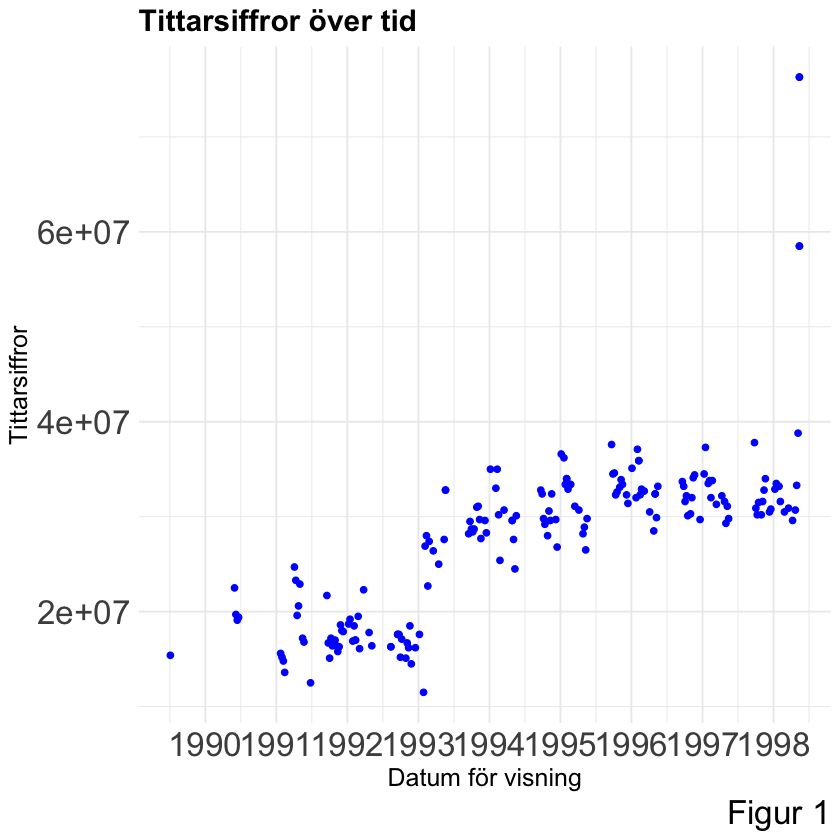

In [93]:
figur_1 <- ggplot(seinfeld_df, aes(x = Originalvisning, y = Tittarsiffror)) +
  geom_point(color = "blue") +  
  scale_x_date( date_breaks = "1 year",  date_labels = "%Y" ) +
  labs(
    title = "Tittarsiffror över tid",
    x = "Datum för visning",
    y = "Tittarsiffror",
    caption = "Figur 1")+
  theme_minimal()+  theme(
    axis.title = element_text(size = 15), 
    axis.text = element_text(size = 20),  
    legend.title = element_text(size = 20), 
    legend.text = element_text(size = 15),  
    plot.title = element_text(size = 18, face = "bold"),
    plot.caption = element_text(size = 20))

figur_1

För att förtydliga detta fenomen presenterar vi en ytterligare visualisering, se figur 2, som tydligare illustrerar:  

1. Seriens enorma framgång under finalen.  
2. Den oväntade uppgången i tittarsiffror mitt i säsong 4.  

Vid en jämförelse med de övriga säsongerna framträder dessa två aspekter som betydligt mer avvikande..

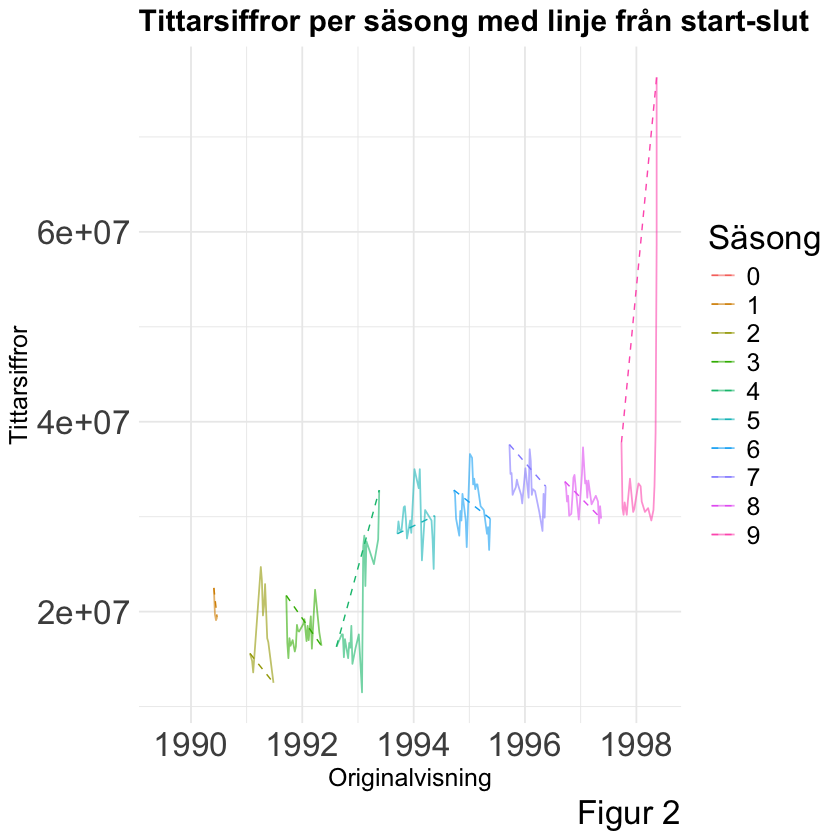

In [94]:
#skapar en data-frame som håller varje säsongs premiär & finals tittarsiffror
season_lines <- seinfeld_df %>%
  group_by(säsong) %>%
  summarize(
    start_date = min(Originalvisning),
    end_date = max(Originalvisning[which.max(`Nr iserien`)]),
    start_tittarsiffror = Tittarsiffror[which.min(Originalvisning)],
    end_tittarsiffror = Tittarsiffror[which.max(`Nr iserien`)], 
    .groups = "drop"
  )

figur_2 <- ggplot(seinfeld_df, aes(x = Originalvisning, y = Tittarsiffror, color = as.factor(säsong))) +
  geom_line(aes(group = säsong), alpha = 0.6) + 
  geom_segment(data = season_lines, aes(
    x = start_date, y = start_tittarsiffror,
    xend = end_date, yend = end_tittarsiffror,
    color = as.factor(säsong)
  ), size = 0.4, linetype = "dashed") + 
  labs(
    title = "Tittarsiffror per säsong med linje från start-slut",
    x = "Originalvisning",
    y = "Tittarsiffror",
    color = "Säsong",
    caption = "Figur 2"
  ) +
  theme_minimal()+  theme(
    axis.title = element_text(size = 15), 
    axis.text = element_text(size = 20),  
    legend.title = element_text(size = 20), 
    legend.text = element_text(size = 15),  
    plot.title = element_text(size = 18, face = "bold") ,
    plot.caption = element_text(size = 20)
  )
figur_2

### The Cheers-Effect

När vi undersöker Seinfelds framgång kan de vara viktigt att även ta hänsyn till externa faktorer också. Två betydande aspekter är sändningsdagarna och sändningstiderna, som kan ha påverkat både tittarsiffror och seriens popularitet:

1. **Veckodagar:** Hur veckodagen påverkar tittarsiffror?
2. **Sändningstider:** Kan olika tider bidrog till förändringar i publikens beteende och programmets framgång?

### Variation av Veckodag
En möjlig förklaring, till fenomen i säsong 4, är förändringen i sändningsdagar. Under seriens gång testades olika veckodagar för att sända Seinfeld, vilket illustreras i figur 3. Här ser vi en solklar ökning i tittarsiffror för avsnitt som sändes på torsdagar jämfört med de som sändes på onsdagar.


[1] "Onsdag"  "Torsdag"

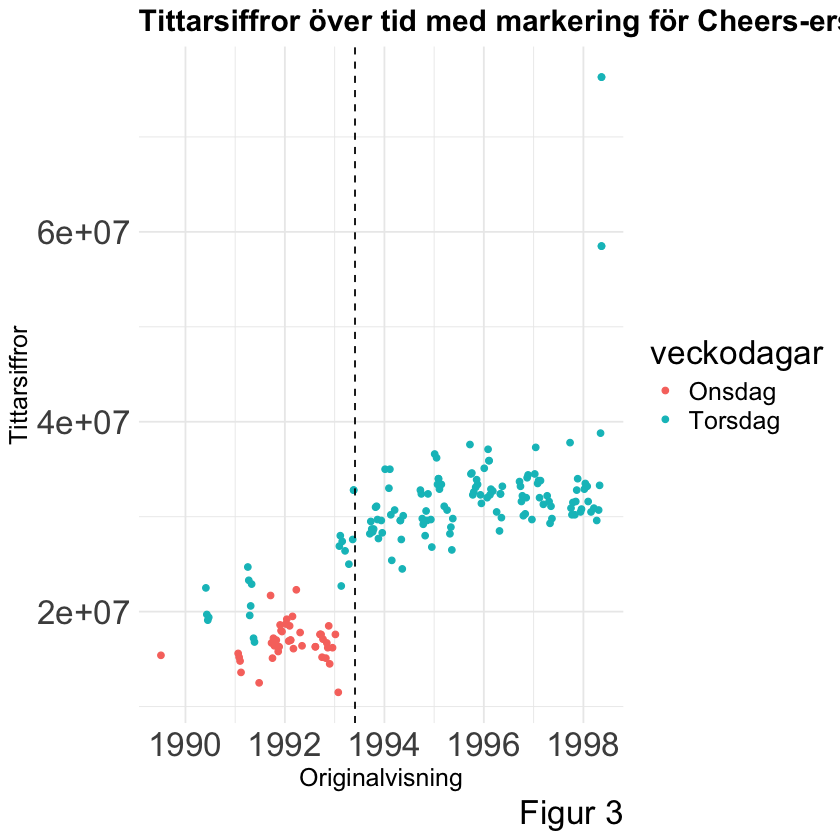

In [95]:
figur_3 <- ggplot(seinfeld_df, aes(x= Originalvisning,y= Tittarsiffror,color = veckodagar)) +
  geom_point() +
 geom_vline(xintercept = as.Date("1993-05-30"), linetype = "dashed", color = "black") +
 labs(
    title = "Tittarsiffror över tid med markering för Cheers-ersättning",
    x = "Originalvisning",
    y = "Tittarsiffror" ,
    caption = "Figur 3")+
  theme_minimal()+  
  theme(
    axis.title = element_text(size = 15), 
    axis.text = element_text(size = 20),  
    legend.title = element_text(size = 20), 
    legend.text = element_text(size = 15),  
    plot.title = element_text(size = 18, face = "bold"),
    plot.caption = element_text(size = 20))
unique(seinfeld_df$veckodagar)
figur_3

#### Variation av Sändningstid
NBC har också varierat sändningstiderna, ibland i samband med att man bytte sändningsdag. I figuren nedan ser vi tittarsiffror kopplade till sändningstiderna. Här illustreras fördelningarna för de två huvudsakliga sändningstiderna: kl. 21:00 och kl. 21:30.

Vi kan se i figur 4.1 att sändningar kl. 21:00 tenderar att ha högre tittarsiffror. Detta resultat bör dock tas med en nypa salt, eftersom den underliggande trenden i tittarsiffror över tid är stigande. Det är rimligt att förvänta sig att serier ofta ökar i popularitet med tiden.


I figur 3 & 4 har en streckad linje markerat det datum då programmet officiellt ersatte den ikoniska serien *Cheers* på NBC:s torsdagskvälls-slot. Detta byte kan ha haft en signifikant inverkan på programmets ökande tittarsiffror och dess position som en av de mest populära sitcoms i historien.

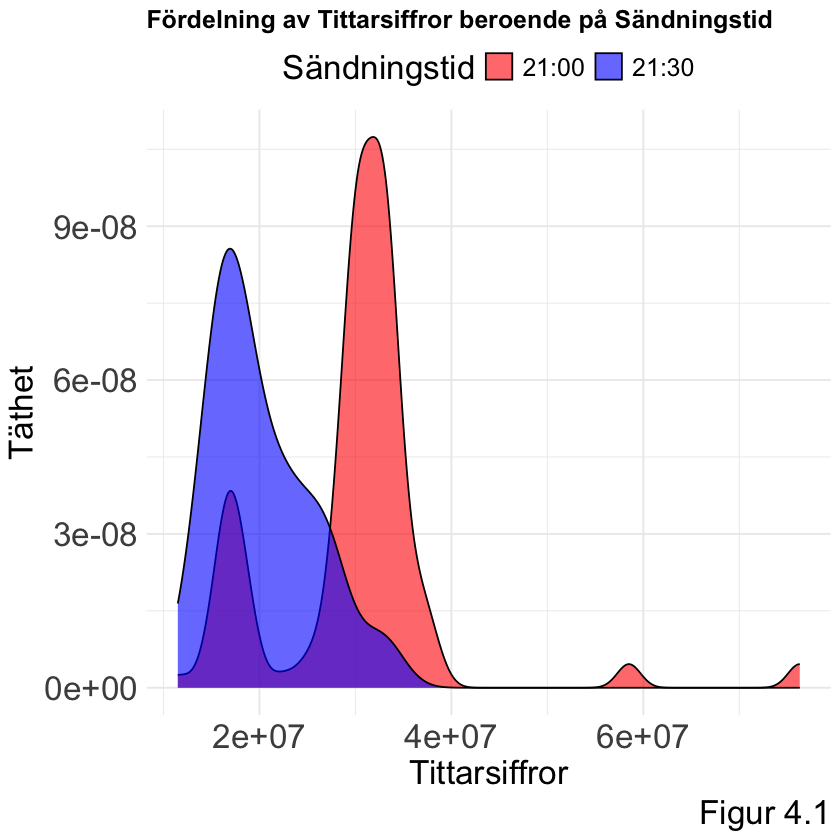

In [96]:
#Fördelning av Tittarsiffror beroende på Sändningstid
plot_4 <- ggplot(seinfeld_df, aes(x = Tittarsiffror, fill = sändningstid)) +
  geom_density(alpha = 0.6) +
  labs(title = "Fördelning av Tittarsiffror beroende på Sändningstid",
       x = "Tittarsiffror",
       y = "Täthet",
       caption = "Figur 4.1") +
  theme_minimal() +
  scale_fill_manual(values = c("21:00:00" = "red", "21:30:00" = "blue"),
                    name = "Sändningstid",
                    labels = c("21:00", "21:30")) +
  theme(legend.position = "top") +
  theme(
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 20),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 15),
    plot.title = element_text(size = 15, face = "bold"),
    plot.caption = element_text(size = 20))
plot_4

I figur 3 & 4 har en streckad linje markerat det datum då programmet officiellt ersatte den ikoniska serien *Cheers* på NBC:s torsdagskvälls-slot. Detta byte kan ha haft en signifikant inverkan på programmets ökande tittarsiffror och dess position som en av de mest populära sitcoms i historien.

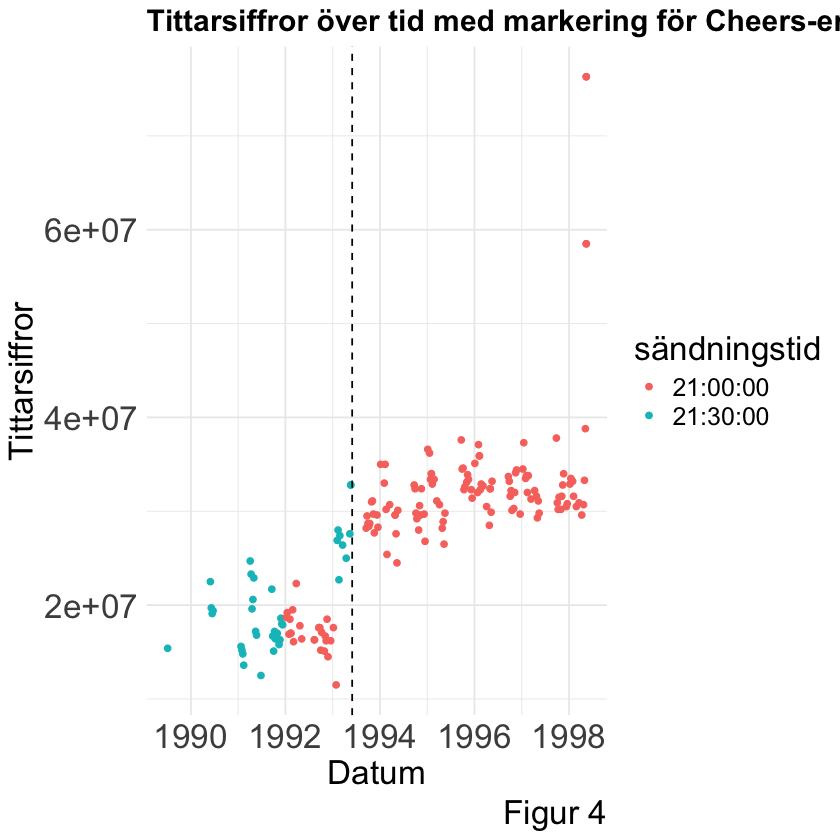

In [97]:
#Tittarsiffror över tid 
figur_4 <- ggplot(seinfeld_df, aes(x = Originalvisning, y = Tittarsiffror, color = sändningstid)) +
  geom_point() +
  geom_vline(xintercept = as.Date("1993-05-31"), linetype = "dashed", color = "black") +
  labs(
    title = "Tittarsiffror över tid med markering för Cheers-ersättning",
    x = "Datum",
    y = "Tittarsiffror",
    caption = "Figur 4" )+
  theme_minimal()+  
  theme(
    axis.title = element_text(size = 20), 
    axis.text = element_text(size = 20),  
    legend.title = element_text(size = 20), 
    legend.text = element_text(size = 15),  
    plot.title = element_text(size = 18, face = "bold"),
    plot.caption = element_text(size = 20))

figur_4

### Vem håller Låda?
En av de mest viktigaste aspekterna av Seinfeld är förståss karaktärerna, där Jerry Seinfeld själv ofta är seriens centrum. Men hur mycket utrymme fick han egentligen i serien, och hur påverkade hans andel av dialogen avsnittens popularitet? Vi har här nedanför,i figur 5, illusterat hans andel av ord som förekommer i varje avsnitt, men också förhållandet av hans dialogandel mot avsnittets betyg.

Med Jerry's ord andel menas:
\[ \text{Jerry's Andel av Ord i Avsnittet}=\frac{\text{Antal Ord Jerry säger i Avsnittet}}{\text{Totala Antal Ord som sägs i Avsnittet}}.\]

Som vi kan se, till vänster i figuren, har Jerrys andel av dialogen i avsnitten minskat genom åren. Detta har gett utrymme för andra karaktärer att ta större plats.

I de tidiga säsongerna, särskilt säsong 1, var Jerrys andel betydligt högre. Detta kan delvis förklaras av hans långa monologer, hämtade direkt från hans standup-rutiner, som visas under avsnitten. Detta format gjorde att han dominerande dialogandel under seriens första år.

I den högra delen av figuren, som visar förhållandet mellan Jerrys dialogandel och avsnittens betyg, framträder ett intressant mönster: avsnitt med höga betyg tenderar att ha en lägre dialogandel för Jerry.

In [98]:
# lägger till jerry's andel per avsnitt
jerry_df <- seindfeld_script_character_proportion %>% 
  filter(Character == "JERRY") %>% 
  select(SEID,share) %>% 
  right_join(seinfeld_df,by = "SEID")

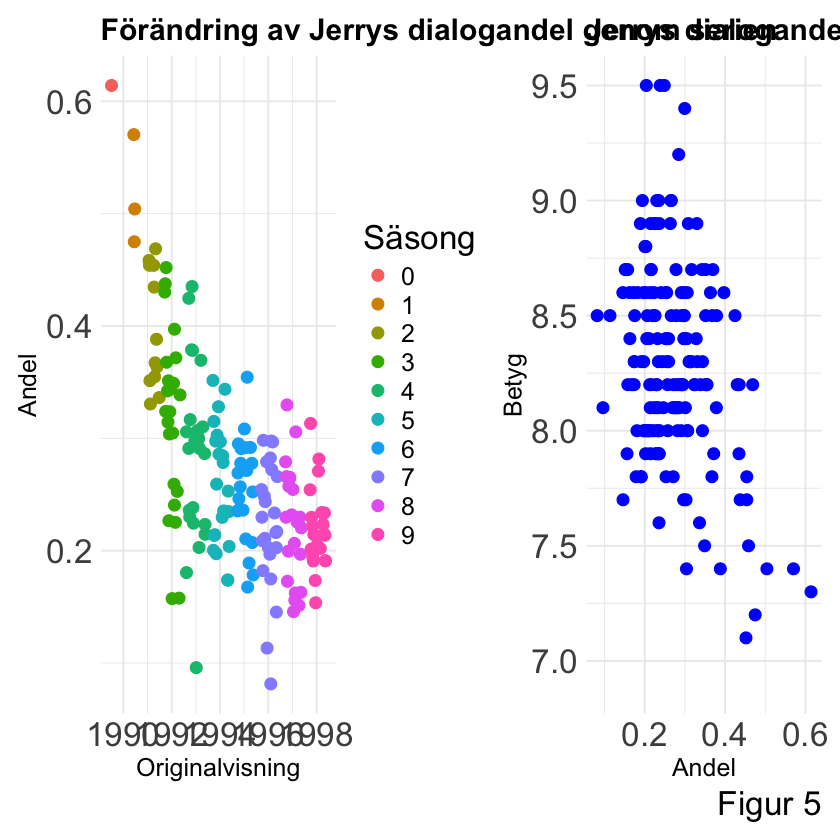

In [75]:
# lägger till jerry's andel per avsnitt
jerry_df <- seindfeld_script_character_proportion %>% 
  filter(Character == "JERRY") %>% 
  select(SEID,share) %>% 
  right_join(seinfeld_df,by = "SEID")

#Jerrys dialogandel genom serien
figur_5.1 <- ggplot(jerry_df,aes(x=Originalvisning,y=share,color=as.factor(säsong)))+
  geom_point(size =3)+
  labs(
    title = "Förändring av Jerrys dialogandel genom serien",
    x = "Originalvisning",
    y = "Andel",
    color = "Säsong")+
  theme_minimal()+  
  theme(
    axis.title = element_text(size = 15), 
    axis.text = element_text(size = 20),  
    legend.title = element_text(size = 20), 
    legend.text = element_text(size = 15), 
    plot.title = element_text(size = 18, face = "bold"),
     plot.caption = element_text(size = 20))

#Jerrys dialogandel mot betyg
figur_5.2 <- ggplot(jerry_df,aes(x=share,y = betyg))+
  geom_point(size =3,color="blue")+
  labs(
    title = "Jerrys dialogandel mot betyg",
    x = "Andel",
    y = "Betyg",
    caption = "Figur 5")+
  theme_minimal()+  
  theme(
    axis.title = element_text(size = 15), 
    axis.text = element_text(size = 20),  
    plot.title = element_text(size = 18, face = "bold"), 
    plot.caption = element_text(size = 20)
    )

figur_5.1+figur_5.2

## Högst & Lägst betygsatta avsnitt

Nedanför, i Figur 6, ser vi en analys av dialogfördelningen i de fem lägst betygsatta och de fem högst betygsatta avsnitten. Den övre raden representerar de lägst betygsatta avsnitten, medan den nedre raden visar de högst betygsatta.

Som vi också kunde observera i Figur 5, har Jerry en signifikant större andel av replikerna i de "sämsta" avsnitten. Detta indikerar att avsnitt där dialogen är starkt centrerad kring Jerry tenderar att få lägre betyg.

I kontrast, i de högst betygsatta avsnitten i raden under, ser vi en mer jämn fördelning av repliker mellan huvudkaraktärerna. Det verkar som om en större balans i dialogen bidrar till avsnittens framgång. Dessutom tycks inkluderingen av biroller spela en viss roll i att höja betyget på dessa avsnitt.

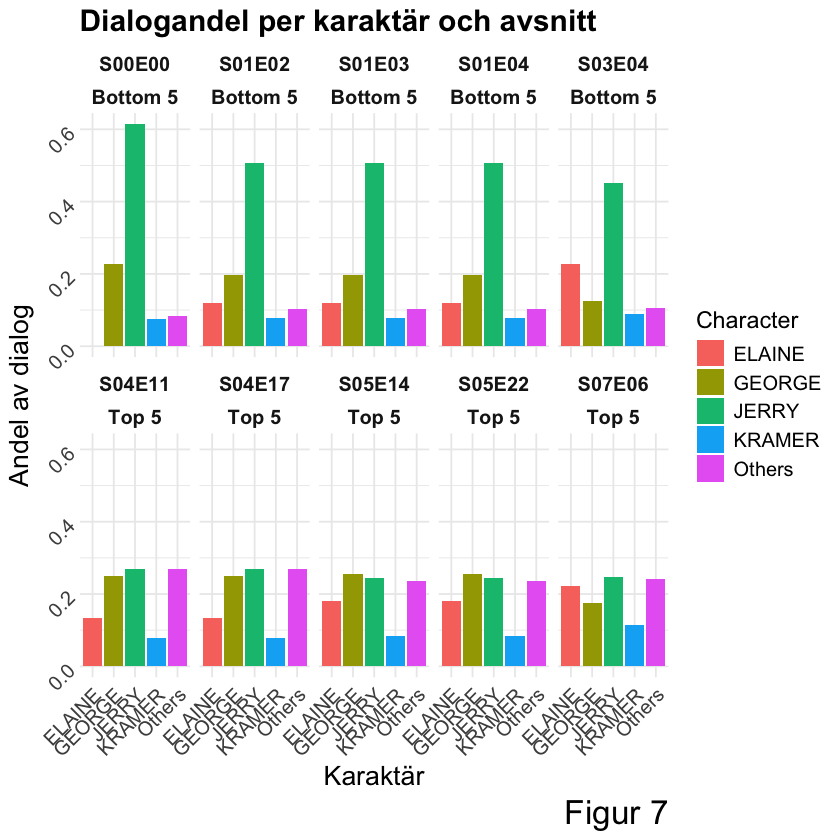

In [67]:
#5 högst rankade avsnitten
top_5 <- seinfeld_df %>%
  arrange(desc(betyg)) %>% 
  head(5) %>% 
  pull(SEID)
#5 lägst rankade avsnitten
bottom_5 <- seinfeld_df %>% 
  filter(!(Titel %in% "The Highlights of a Hundred")) %>%  #saknar script pga "återblick"-avsnitt
  arrange(betyg) %>% 
  head(5) %>% 
  pull(SEID)


top_and_bottom <- c(top_5,bottom_5)
season_and_SEID <- seinfeld_df %>% 
  select(SEID,säsong)

# skapar en df som håller karaktärernas ord för de bästa och sämsta avsnitten.
top_and_bottom_5 <- seindfeld_script_character_proportion %>% 
  filter(SEID %in% top_and_bottom) %>% 
  mutate(rang = ifelse(SEID %in% top_5,"Top 5","Bottom 5")) %>% 
  left_join(season_and_SEID,by = "SEID") %>% 
  group_by(säsong,Character) %>% 
  reframe(medel_share = mean(share), SEID,rang) %>% 
  arrange(SEID)

figur_7 <- ggplot(top_and_bottom_5, aes(x = Character, y = medel_share, fill = Character)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ SEID+rang, ncol = 5, nrow = 2) +  
  labs( 
    title = "Dialogandel per karaktär och avsnitt",
    x = "Karaktär",
    y = "Andel av dialog",
    caption = "Figur 6") +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 12, angle = 45, hjust = 1),  
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(size = 18, face = "bold"),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),
     plot.caption = element_text(size = 20))
figur_7

## Diskussion
Seinfeld, en av de mest ikoniska serierna i tv-historien. Genom att kombinera data från flera källor, såsom tittarsiffror, IMDb-betyg, manuskript och sändningstider, har vi fått en djupare insikt i seriens utveckling och dess kulturella påverkan.

### Manuskript roll och balans
Analysen av dialogfördelningen mellan karaktärerna visar intressanta samband. Under de första säsongerna var Jerry Seinfeld själv den centrala figuren, vilket reflekteras i hans höga andel av dialogen. Men med tiden utvecklades serien, och dialogen fördelades mer jämnt mellan huvudkaraktärerna. Denna förändring verkar ha bidragit till högre betyg, vilket tyder på att en balans mellan karaktärerna spelar en viktig roll för seriens framgång.

### Tittarsiffrorna
Tittarsiffrorna visar en tydlig uppåtgående trend, särskilt efter 1993. Denna ökning sammanfaller med att serien flyttades till NBC:s attraktiva torsdagskvälls-slot, där den efterträdde den ikoniska serien Cheers. Detta skifte, som vi kallar "The Cheers Effect", verkar ha haft en betydande inverkan på Seinfelds popularitet.

### Utvecklingsområden
De högst betygsatta avsnitten visar också ett gemensamt mönster att en mer balanserad fördelning av repliker mellan huvudkaraktärerna och ett ökat utrymme för biroller. Detta kan tyda på att interaktioner mellan karaktärerna är en viktig faktor för publikens uppskattning. Ett intressant utvecklingsområde för vidare analys skulle kunna vara att identifiera vilka specifika karaktärsinteraktioner eller relationer som är mest populära och hur dessa påverkar betygen.

En spännande analys skulle vara att titta på hur betyget förändras varje avsnitt beroende på regisör och manusförfattare, eller om manusförfattare har "favorit"-karaktärer, som de tenderar att ge fler repliker än vad andra författare gör.

En annan aspekt att utforska är hur faktorer som ekonomiska förhållanden kan påverka tittarsiffrorna. Till exempel skulle arbetslöshet kunna vara en intressant variabel att analysera, fler arbetslösa skulle potentiellt kunna innebära en större publik, vilket kan ha påverkat seriers framgång under olika perioder.